In [173]:
import pandas as pd
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
import folium

# Bangkok District Population - Data Mining

### Table of Contents

1. [Associate census blocks with district bounds](#census-districts)
    
2. [Handle MultiPolygon district](#bang-sai)
    
3. [Visualize District Population Density](#viz-density)

### Inputs/Outputs
Required inputs:
- 'data/Bangkok_districts.shp' (as generated in './Bangkok_venues.ipynb')

Outputs:
- 'data/Bangkok_districts_population.shp'

## Associate census blocks with district bounds
<a id="census-districts"></a>

In [11]:
# Load census data from url
census_df = pd.read_html('https://www.citypopulation.de/en/thailand/admin/')[0]
census_df.head()

,Name,Native,Status,PopulationCensus2000-04-01,PopulationCensus2010-09-01,Unnamed: 5
0,Amnat Charoen,จังหวัดอำนาจเจริญ,Province,359360,283732,→
1,Chanuman,อำเภอชานุมาน,District,34510,32283,→
2,Hua Taphan,อำเภอหัวตะพาน,District,49435,37273,→
3,Lue Amnat,อำเภอลืออำนาจ,District,36820,28454,→
4,Mueang Amnat Charoen,อำเภอเมืองอำนาจเจริญ,District,127789,101768,→


In [80]:
# Load district bounds from file
districts_gdf = gpd.read_file('data/Bangkok_districts.shp')
districts_gdf.set_index('district',drop=True,inplace=True)
districts_gdf.head()

,geometry
district,
Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410..."
Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703..."
Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667..."
Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669..."
Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986..."


In [55]:
#'Chom Thong' district has duplicate romanized name - drop it before reindexing
census_df[census_df.Name=='Chom Thong']

,Name,Native,Status,PopulationCensus2000-04-01,PopulationCensus2010-09-01,Unnamed: 5
101,Chom Thong,อำเภอจอมทอง,District,60710,70546,→
260,Chom Thong,เขตจอมทอง,City District,195602,197409,→


In [58]:
# Drop same-named needed district
census_df.drop(101,inplace=True)

In [59]:
# Set district name as index
census_df.set_index('Name',drop=True,inplace=True)
census_df

,Native,Status,PopulationCensus2000-04-01,PopulationCensus2010-09-01,Unnamed: 5
Name,,,,,
Amnat Charoen,จังหวัดอำนาจเจริญ,Province,359360,283732,→
Chanuman,อำเภอชานุมาน,District,34510,32283,→
Hua Taphan,อำเภอหัวตะพาน,District,49435,37273,→
Lue Amnat,อำเภอลืออำนาจ,District,36820,28454,→
Mueang Amnat Charoen,อำเภอเมืองอำนาจเจริญ,District,127789,101768,→
...,...,...,...,...,...
Mueang Yasothon,อำเภอเมืองยโสธร,District,133910,130313,→
Pa Tio,อำเภอป่าติ้ว,District,36326,31773,→
Sai Mun,อำเภอทรายมูล,District,32917,24785,→


In [87]:
# Join district geometry with district population
districts_pop_gdf = districts_gdf.join(census_df[['PopulationCensus2010-09-01']])
districts_pop_gdf.columns=['geometry','population']
districts_pop_gdf

,geometry,population
Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410...",64323.0
Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703...",45252.0
Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667...",105742.0
Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669...",138698.0
Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986...",256290.0
...,...,...
Wang Noi,"POLYGON ((100.82285 14.32829, 100.82439 14.326...",86342.0
Wang Thonglang,"POLYGON ((100.58796 13.80530, 100.58826 13.805...",224013.0
Wattana,"POLYGON ((100.55692 13.75175, 100.55806 13.751...",NaN
Wihan Daeng,"POLYGON ((100.99131 14.42083, 100.99177 14.418...",48899.0


In [98]:
# Manually fill population for districts with varying Romanized names
def fill_census_block(find, replace):
    districts_pop_gdf.loc[find,'population'] = \
        census_df.at[replace,'PopulationCensus2010-09-01']
    return

fill_census_block('K. Bang Sao Thon','Bang Sao Thong')
fill_census_block('Bang Plee','Bang Phli')
fill_census_block('Muang Samut Prakan','Mueang Samut Prakan')
fill_census_block('Phra Pra Daeng','Phra Pradaeng')
fill_census_block('Phra Samut Jadee','Phra Samut Chedi')
fill_census_block('Bangkhuntien','Bang Khun Thian')
fill_census_block('Muang Samut Sakhon','Mueang Samut Sakhon')
fill_census_block('Thungkru','Thung Khru')
fill_census_block('Nong Sua','Nong Suea')
fill_census_block('Bang Pa-In','Bang Pa-in')
fill_census_block('Muang Pathum Thani','Mueang Pathum Thani')
fill_census_block('Don Muang','Don Mueang')
fill_census_block('Muang Nonthaburi','Mueang Nonthaburi')
fill_census_block('Phuttha Mon Thon','Phutthamonthon')
fill_census_block('Thawi Wattana','Thawi Watthana')
fill_census_block('Nongkheam','Nong Khaem')
fill_census_block('Bung Kum','Bueng Kum')
fill_census_block('Bang Su','Bang Sue')
fill_census_block('Bang Plad', 'Bang Phlat')
fill_census_block('Din Dang','Din Daeng')
fill_census_block('Pom Pram Sattru','Pom Prap Sattru Phai')
fill_census_block('Samphantawong', 'Samphanthawong')
fill_census_block('Huai Kwang','Huai Khwang')
fill_census_block('Wattana','Watthana')
fill_census_block('Yannawa','Yan Nawa')
fill_census_block('Khlong Toey','Khlong Toei')
fill_census_block('Sathorn','Sathon')
fill_census_block('Prakanong','Phra Khanong')
fill_census_block('Muang Chachoengsao','Mueang Chachoengsao')
fill_census_block('Bang Nam Prieo','Bang Nam Priao')

## Handle MultiPolygon district
<a id='bang-sai' />

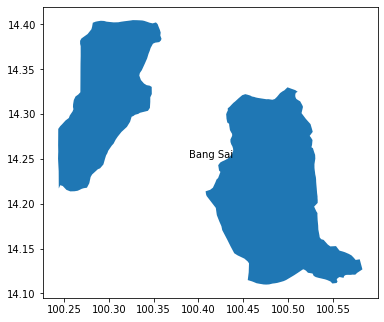

In [147]:
# Visualize remaining districts with missing population
fig,ax = plt.subplots(figsize=(6,6))
districts_pop_gdf[districts_pop_gdf.population.isna()].plot(ax=ax)
for i,d in districts_pop_gdf[districts_pop_gdf.population.isna()].iterrows():
    ax.annotate(i,d.geometry.centroid.coords[0],ha='center')
plt.show()

In [163]:
# Reset Bang Sai to represent Bang Sai District (1404) 
# and not lesser-connected Bang Sai District (1413)

bangsai_districts = list(districts_pop_gdf.loc['Bang Sai'].geometry)

districts_pop_gdf.loc['Bang Sai (1404)'] = {\
    'geometry': bangsai_districts[0],\
    'population': census_df.at['Bang Sai (1404)','PopulationCensus2010-09-01']\
}

In [168]:
# Drop MultiPolygon district
districts_pop_gdf.drop('Bang Sai',inplace=True)
districts_pop_gdf

,geometry,population
Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410...",64323.0
Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703...",45252.0
Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667...",105742.0
Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669...",138698.0
Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986...",256290.0
...,...,...
Wang Thonglang,"POLYGON ((100.58796 13.80530, 100.58826 13.805...",224013.0
Wattana,"POLYGON ((100.55692 13.75175, 100.55806 13.751...",171150.0
Wihan Daeng,"POLYGON ((100.99131 14.42083, 100.99177 14.418...",48899.0
Yannawa,"POLYGON ((100.54800 13.72229, 100.55074 13.721...",182621.0


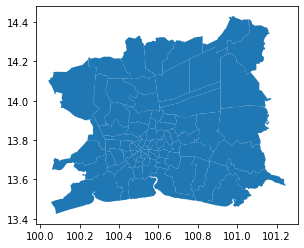

In [169]:
# Plot new bounds
districts_pop_gdf.plot()

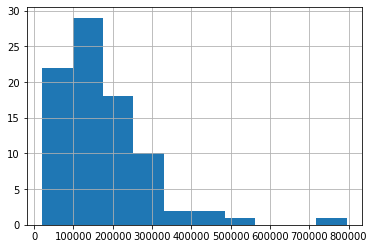

In [171]:
# Visualize district population distribution
districts_pop_gdf.population.hist()

In [185]:
# While this CRS should be projected for area calculations, 
# this is only used for visualization purposes below

districts_pop_gdf['area_sqkm'] =\
    districts_pop_gdf.apply(lambda n: n.geometry.area/10**6, axis=1)
districts_pop_gdf['population_density'] =\
    districts_pop_gdf['population']/districts_pop_gdf['area_sqkm']
districts_pop_gdf

,geometry,population,area_sqkm,population_density
Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410...",64323.0,2.951617e-08,2.179246e+12
Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703...",45252.0,1.733921e-08,2.609807e+12
Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667...",105742.0,1.827028e-08,5.787650e+12
Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669...",138698.0,3.017369e-09,4.596654e+13
Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986...",256290.0,1.106805e-08,2.315584e+13
...,...,...,...,...
Wang Thonglang,"POLYGON ((100.58796 13.80530, 100.58826 13.805...",224013.0,1.434320e-09,1.561806e+14
Wattana,"POLYGON ((100.55692 13.75175, 100.55806 13.751...",171150.0,1.073738e-09,1.593965e+14
Wihan Daeng,"POLYGON ((100.99131 14.42083, 100.99177 14.418...",48899.0,1.910760e-08,2.559139e+12
Yannawa,"POLYGON ((100.54800 13.72229, 100.55074 13.721...",182621.0,1.233046e-09,1.481055e+14


In [193]:
# Format dataframe for saving
districts_pop_gdf_tosave = districts_pop_gdf.reset_index()
districts_pop_gdf_tosave.columns=['district','geometry','population','area_sqkm','population_density']
districts_pop_gdf_tosave

,district,geometry,population,area_sqkm,population_density
0,Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410...",64323.0,2.951617e-08,2.179246e+12
1,Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703...",45252.0,1.733921e-08,2.609807e+12
2,Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667...",105742.0,1.827028e-08,5.787650e+12
3,Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669...",138698.0,3.017369e-09,4.596654e+13
4,Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986...",256290.0,1.106805e-08,2.315584e+13
...,...,...,...,...,...
80,Wang Thonglang,"POLYGON ((100.58796 13.80530, 100.58826 13.805...",224013.0,1.434320e-09,1.561806e+14
81,Wattana,"POLYGON ((100.55692 13.75175, 100.55806 13.751...",171150.0,1.073738e-09,1.593965e+14
82,Wihan Daeng,"POLYGON ((100.99131 14.42083, 100.99177 14.418...",48899.0,1.910760e-08,2.559139e+12
83,Yannawa,"POLYGON ((100.54800 13.72229, 100.55074 13.721...",182621.0,1.233046e-09,1.481055e+14


In [194]:
# Save district population dataset
districts_pop_gdf_tosave.to_file('data/Bangkok_districts_population.shp')

## Visualize district population density
<a id='viz-density' />

In [187]:
# Restructure dataframe for plotting
districts_pop_df = districts_pop_gdf[['population','population_density']]
districts_pop_df.reset_index(inplace=True)
districts_pop_df.columns=['district','population','population_density']
districts_pop_df

,district,population,population_density
0,Ban Na,64323.0,2.179246e+12
1,Ban Pho,45252.0,2.609807e+12
2,Bang Bo,105742.0,5.787650e+12
3,Bang Bon,138698.0,4.596654e+13
4,Bang Bua Thong,256290.0,2.315584e+13
...,...,...,...
80,Wang Thonglang,224013.0,1.561806e+14
81,Wattana,171150.0,1.593965e+14
82,Wihan Daeng,48899.0,2.559139e+12
83,Yannawa,182621.0,1.481055e+14


In [188]:
# Plot population density by district
loc = districts_pop_gdf.assign(city="Bangkok").dissolve(by='city').centroid

city_map = folium.Map(
    location=(loc.y,loc.x),
    zoom_start=10,
    tiles='cartodbpositron'
)

folium.Choropleth(
    geo_data=districts_pop_gdf,
    name='choropleth',
    data=districts_pop_df,
    columns=['district','population_density'],
    key_on='feature.id',
    fill_color='Reds',
    bins=5,
    legend_name='Population Density (per sqkm)'
).add_to(city_map)

city_map